# AI Agent Framework

In this notebook we will use a couple of the AI agent frameworks to simplify our code.

We will:

* [Reuse the local SQL Database](#reuse-local-sql-database)
* [Adjust the system prompt](#adjusting-the-system-prompt)
* [Add dynamic code tool](#add-dynamic-code-tool-to-the-sql-tools)
* [Create secure sandbox exnvironment](#creating-a-secure-sandbox-to-the-code-execution)
* [Add the new dynmaic tool to the script](#add-the-new-tool-to-chat-script)

### Visual improvements

We will use [rich library](https://github.com/Textualize/rich), and `rich-theme-manager` to make the output more readable, and supress warning messages.

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Reuse local SQL database

We will reuse the local SQLite database that we created in the previous hands-on lab, and also reuse the SQLDatabase class that we defined there.

In [3]:
import sqlite3
import json

class SQLDatabase:
    def __init__(self):
        self.db_name = 'baseball.db'

    def get_db_schema(self):
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        # Get schema for player table
        cursor.execute("PRAGMA table_info(player)")
        player_schema = cursor.fetchall()
        
        # Get schema for salary table 
        cursor.execute("PRAGMA table_info(salary)")
        salary_schema = cursor.fetchall()
        
        conn.close()
        
        return json.dumps({
            'player': player_schema,
            'salary': salary_schema
        })    

    def execute_sql_query(self, sql_query: str):
    
        # Connect to SQLite database
        conn = sqlite3.connect(self.db_name)
        cursor = conn.cursor()
        
        # Execute query
        cursor.execute(sql_query)
        
        # Fetch results
        results = cursor.fetchall()
        
        # Get column names
        column_names = [description[0] for description in cursor.description]
        
        # Convert results to list of dicts
        results_list = []
        for row in results:
            row_dict = dict(zip(column_names, row))
            results_list.append(row_dict)
            
        # Close connection
        conn.close()
        
        # Return JSON string
        return json.dumps(results_list)

In [4]:
db = SQLDatabase()
db.execute_sql_query("SELECT count(*) FROM player")

'[{"count(*)": 18846}]'

## Adjusting the System Prompt

We used before a short system prompt that was fine for the simple SQL flow. We will extend the prompt to allow the AI agent to geenrate visualization by generating python code dynamically. 

In [5]:
system_prompt = """
You are an expert business analyst with deep knowledge of SQL and visualization code in Python.
Your job is to help users understand and analyze their internal baseball data.
Be helpful and brief in your responses.
You have access to a set of tools, but only use them when needed. 
You also have access to a tool that allows execution of python code. Use it to generate the visualizations in your analysis.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

In [6]:
from dotenv import load_dotenv

load_dotenv()

True

In [58]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from e2b_code_interpreter import Sandbox

# The tool definition uses the function signatures
@tool
def code_interpret(code):
    """Execture the given python code in a secure sandbox environment.
    Args:
        code (str): the python code to execute.
    Returns:
        figure: the visualization chart that was generated from the python code.
    """
    console.print("Running code interpreter...")

    with Sandbox() as code_interpreter:
        exec = code_interpreter.run_code(code,
        on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
        on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

        if exec.error:
            print("[Code Interpreter ERROR]", exec.error)
        else:
            # We only return chart output that are png base64 objects
            return exec.results[0].png

@tool
def get_db_schema():
    """Returns the schema of the SQLite database with the baseball data about players (player table) and salaries (salary table).
    Args:
        None.
    Returns:
        schema : string dump of the JSON object that describes the `player` and `salary` tables.
    """
    return db.get_db_schema()

@tool
def execute_sql_query(sql_query: str):
    """Executes the SQL query on the SQLite database and returns the query results.
    Args:
        sql_query (str): the sql query to execute.
    Returns:
        results : string dump of the JSON object that describes results of the sql query.
    """
    return db.execute_sql_query(sql_query)

# Below is one example of a simple react agent
sql_agent = create_react_agent(
    ChatOpenAI(model="gpt-4o-mini"),
    tools=[
        code_interpret, 
        get_db_schema, 
        execute_sql_query
    ],
    state_modifier=system_prompt,
)

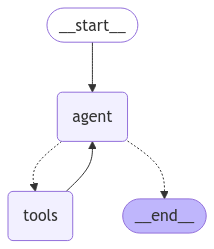

In [55]:
from IPython.display import Image, display

display(Image(sql_agent.get_graph().draw_mermaid_png()))

In [9]:
user_prompt = """
What were the top 10 states where baseball players were born in the 80's and compare it to the 70's? 
Please show the results with a bar chart.
"""

In [84]:
from langchain_core.messages.ai import AIMessage
from langchain_core.messages.tool import ToolMessage
from rich.syntax import Syntax
from IPython.display import display, HTML
from base64 import b64decode

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        # console.print(message)
        if isinstance(message, AIMessage):
            message.pretty_print()
            tool_calls = message.tool_calls
            for tool_call in tool_calls:
                tool_name = tool_call['name']
                tool_input = tool_call['args']
                if tool_name == 'execute_sql_query':
                    syntax = Syntax(tool_input['sql_query'], "sql", line_numbers=True)
                    console.print(syntax)
                elif tool_name == "code_interpret":
                    syntax = Syntax(tool_input['code'], "python", line_numbers=True)
                    console.print(syntax)
        elif isinstance(message, ToolMessage):
            message.pretty_print()
            if message.name == 'code_interpret':
                base64_data = message.content
                display(HTML(f'<img src="data:image/png;base64,{base64_data}" />'))
        elif isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

================================ Human Message =================================


What were the top 10 states where baseball players were born in the 80's and compare it to the 70's? 
Please show the results with a bar chart.

================================== Ai Message ==================================
Tool Calls:
  execute_sql_query (call_zDf5AjVJe2Vp5GHIW7tUS0fL)
 Call ID: call_zDf5AjVJe2Vp5GHIW7tUS0fL
  Args:
    sql_query: SELECT state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1980 AND 1989 GROUP BY state ORDER BY player_count DESC LIMIT 10;
  execute_sql_query (call_0KNlOW4feNS8ih3sGQttd5dT)
 Call ID: call_0KNlOW4feNS8ih3sGQttd5dT
  Args:
    sql_query: SELECT state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1970 AND 1979 GROUP BY state ORDER BY player_count DESC LIMIT 10;


  1 SELECT state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1980 AND 1989 GROUP BY state ORDER 

  1 SELECT state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1970 AND 1979 GROUP BY state ORDER 

================================= Tool Message =================================
Name: execute_sql_query

Error: OperationalError('no such column: state')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  get_db_schema (call_0oCd5dbqbzsyMtMHXlIPYr1K)
 Call ID: call_0oCd5dbqbzsyMtMHXlIPYr1K
  Args:
================================= Tool Message =================================
Name: get_db_schema

{"player": [[0, "player_id", "TEXT", 0, null, 0], [1, "birth_year", "REAL", 0, null, 0], [2, "birth_month", "REAL", 0, null, 0], [3, "birth_day", "REAL", 0, null, 0], [4, "birth_country", "TEXT", 0, null, 0], [5, "birth_state", "TEXT", 0, null, 0], [6, "birth_city", "TEXT", 0, null, 0], [7, "death_year", "REAL", 0, null, 0], [8, "death_month", "REAL", 0, null, 0], [9, "death_day", "REAL", 0, null, 0], [10, "death_country", "TEXT", 0, null, 0], [11, "death_state", "TEXT", 0, null, 0], [12, "death_city", "TEXT", 0, null, 0]

  1 SELECT birth_state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1980 AND 1989 GROUP BY birth_

  1 SELECT birth_state, COUNT(*) as player_count FROM player WHERE birth_year BETWEEN 1970 AND 1979 GROUP BY birth_

================================= Tool Message =================================
Name: execute_sql_query

[{"birth_state": "CA", "player_count": 334}, {"birth_state": "TX", "player_count": 106}, {"birth_state": null, "player_count": 104}, {"birth_state": "FL", "player_count": 101}, {"birth_state": "IL", "player_count": 79}, {"birth_state": "NY", "player_count": 71}, {"birth_state": "OH", "player_count": 57}, {"birth_state": "PA", "player_count": 51}, {"birth_state": "Distrito Nacional", "player_count": 50}, {"birth_state": "GA", "player_count": 47}]
================================== Ai Message ==================================
Tool Calls:
  code_interpret (call_NU2Ox3jqQvs1okfRwNh7lUHF)
 Call ID: call_NU2Ox3jqQvs1okfRwNh7lUHF
  Args:
    code: import matplotlib.pyplot as plt
import numpy as np

# Data for 1980s
states_80s = ['CA', 'TX', 'FL', 'Unknown', 'GA', 'Distrito Nacional', 'IL', 'OH', 'PA', 'NY']
counts_80s = [334, 169, 148, 72, 61, 60, 55, 48, 37, 35]

# Data for 1970s
states

   1 import matplotlib.pyplot as plt                                                                               
   2 import numpy as np                                                                                            
   3                                                                                                               
   4 # Data for 1980s                                                                                              
   5 states_80s = ['CA', 'TX', 'FL', 'Unknown', 'GA', 'Distrito Nacional', 'IL', 'OH', 'PA', 'NY']                 
   6 counts_80s = [334, 169, 148, 72, 61, 60, 55, 48, 37, 35]                                                      
   7                                                                                                               
   8 # Data for 1970s                                                                                              
   9 states_70s = ['CA', 'TX', 'Unknown', 'FL', 'IL', 'NY', 'OH', 'PA', 'Distrito Nacional', 'GA']                 
  10 counts_70s = [334, 106, 104, 101, 79, 71, 57, 51, 50, 47]                                                     
  11                                                                                                               
  12 # Set up the bar chart                                                                                        
  13 bar_width = 0.35                                                                                              
  14 index = np.arange(len(states_80s))                                                                            
  15                                                                                                               
  16 # Create bars for both decades                                                                                
  17 bars1 = plt.bar(index, counts_80s, bar_width, label='1980s')                                                  
  18 bars2 = plt.bar(index + bar_width, counts_70s, bar_width, label='1970s')                                      
  19                                                                                                               
  20 # Adding labels and title                                                                                     
  21 plt.xlabel('States')                                                                                          
  22 plt.ylabel('Number of Players')                                                                               
  23 plt.title('Top 10 States with Baseball Players Born in the 1980s vs 1970s')                                   
  24 plt.xticks(index + bar_width 

Running code interpreter...

================================= Tool Message =================================
Name: code_interpret

iVBORw0KGgoAAAANSUhEUgAAAnYAAAHWCAYAAAD6oMSKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAB7JElEQVR4nO3dd1QU198G8GfpHUQpErErgg3ERrA3RGPFbpQYNRaMUaxYY6+x16ix99iNDXvvoti7qDQFAQGl7X3/8GV+roDu6sLC+nzO2aM7Mzv7nWHLs3fu3JEJIQSIiIiIKM/T0XQBRERERKQeDHZEREREWoLBjoiIiEhLMNgRERERaQkGOyIiIiItwWBHREREpCUY7IiIiIi0BIMdERERkZZgsCMiIiLSEgx2RGpy/PhxyGQyHD9+XOll//333+wvTENkMhn69euntvVltn9/+eUXFC1aVG3Poe710beRyWT4888/s/15vof3I30/GOy+gUwmU+qmzBf9t1q8eDHatm2LwoULQyaT4Zdffsly2ZiYGPz222+wsbGBqakp6tati6tXryr1PHK5HGvWrEG1atVgbW0Nc3NzlC5dGl27dsX58+el5W7fvo0///wTT58+/ept2rBhA+bMmfPVj88NsmsbVq1aleF1Zmtri7p162L//v1qf768rk6dOgr7ytraGlWqVME///wDuVyu6fJyTNGiRRX2g5GREUqVKoUhQ4YgOjpa0+Vlu9zwmaLKZ3VgYCBq1KgBExMT5MuXD23atMn0M/X9+/eYMmUKXFxcYGJigh9++AFt27bFrVu3Miz7LZ//uYG69196qM/qNmnSJIXl88L+09N0AXnZ2rVrFe6vWbMGgYGBGaY7Oztney3Tpk3D27dvUbVqVYSFhWW5n


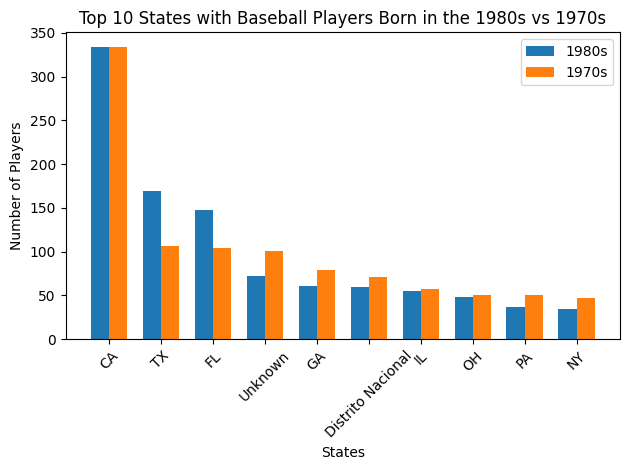

================================== Ai Message ==================================

The bar chart comparing the top 10 states where baseball players were born in the 1980s and 1970s has been generated. 

Here's a summary of the results:

### Top 10 States for Baseball Players Born in the 1980s:
1. California (CA) - 334 players
2. Texas (TX) - 169 players
3. Florida (FL) - 148 players
4. Unknown - 72 players
5. Georgia (GA) - 61 players
6. Distrito Nacional - 60 players
7. Illinois (IL) - 55 players
8. Ohio (OH) - 48 players
9. Pennsylvania (PA) - 37 players
10. New York (NY) - 35 players

### Top 10 States for Baseball Players Born in the 1970s:
1. California (CA) - 334 players
2. Texas (TX) - 106 players
3. Unknown - 104 players
4. Florida (FL) - 101 players
5. Illinois (IL) - 79 players
6. New York (NY) - 71 players
7. Ohio (OH) - 57 players
8. Pennsylvania (PA) - 51 players
9. Distrito Nacional - 50 players
10. Georgia (GA) - 47 players

### Bar Chart
The chart visually represents the

In [85]:
inputs = {"messages": [("user", user_prompt)]}
print_stream(sql_agent.stream(inputs, stream_mode="values"))
